**Table of contents**<a id='toc0_'></a>    
- [Investigação das funcionalidades do Ticker](#toc1_)    
    - [Função conveniente para usar o pandas datareader](#toc1_1_1_)    
  - [Plot de candlesticks e linha](#toc1_2_)    
  - [Coleta de preço de mercado do ticker](#toc1_3_)    
- [Implementação de cálculos a partir de planilha de operações da Dlombello](#toc2_)    
  - [Salva dados da planilha em parquet](#toc2_1_)    
  - [Cálculos da ação](#toc2_2_)    
- [Teste de ações estrangeiras](#toc3_)    
- [Teste de ações estrangeiras com dividendos](#toc4_)    
  - [Importação de cotações do dólar do Banco Central](#toc4_1_)    
    - [Identificação de PTAX para as operações](#toc4_1_1_)    
- [Tratando Ações com Splits e Inplits](#toc5_)    
- [Tratando FIIs](#toc6_)    
- [Futuro](#toc7_)    
  - [Tratando Renda Fixa](#toc7_1_)    
  - [Tratando Cryptos](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---

#TODO: O que fazer com ativos que não estão mais listados como BRDT3?

#TODO: Tratar FIIs -> Subscrição é tratado como compra já.

#TODO: Calcular lucro em aberto por ação na carteira a partir da cotação do mercado.

#TODO: Obtenção de dados de benchmark do ibovespa, s&p500, cdi, ipca e ifix.

#TODO: plot de resultados por ação vs benchmark

In [2]:
import yfinance as yf

Utiliza-se de cache para diminuir as requisições

In [3]:
import requests_cache
session = requests_cache.CachedSession('yfinance.cache')
session.headers['User-agent'] = 'my-program/1.0'

Limita o número de requisições para não estourar o limite de uso da API

In [4]:
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5)),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache"),
)

In [5]:
import pandas as pd

Coleta todos os dados de stocks da API do yahoo

In [6]:
all_tickers = yf.Ticker('MSFT', session=session)

Utiliza uma API para coletar de forma organizada ações brasileiras e americanas

In [7]:
from stocksymbol import StockSymbol
api_key = 'edc2e477-017b-4503-a9dd-f62cbc971c3b'
ss = StockSymbol(api_key)

In [110]:
def get_ticker(ticker):

    symbol_list_us = ss.get_symbol_list(market="US", symbols_only=True) # "us" or "america" will also work
    symbol_list_br = ss.get_symbol_list(market="BR", symbols_only=True)
    symbols_list_br_simple = [symbol.split('.')[0] for symbol in symbol_list_br]

    if ticker in symbol_list_us:
        print(f"{ticker} is in US market")
    elif ticker in symbols_list_br_simple:
        print(f"{ticker} is in SA market")
        ticker = ticker + '.SA'
    else:
        raise ValueError(f'Ticker {ticker} not found in US and SA markets.')
    
    print("Requesting ticker info...")
    ticker = yf.Ticker(ticker, session=session)
    return ticker

In [8]:
# get symbol list based on market
symbol_list_us = ss.get_symbol_list(market="US", symbols_only=True) # "us" or "america" will also work
symbol_list_br = ss.get_symbol_list(market="BR", symbols_only=True)

In [9]:
symbols_list_br_simple = [symbol.split('.')[0] for symbol in symbol_list_br]

In [104]:
symbols_list_br_simple

['AAPL34',
 'MSFT34',
 'GOGL34',
 'GOGL35',
 'AMZO34',
 'TSLA34',
 'FBOK34',
 'BERK34',
 'NVDC34',
 'H1SB34',
 'VISA34',
 'JNJB34',
 'UNHH34',
 'HOME34',
 'WALM34',
 'PGCO34',
 'MSCD34',
 'PFIZ34',
 'EXXO34',
 'DISB34',
 'COCA34',
 'CSCO34',
 'AVGO34',
 'LILY34',
 'NIKE34',
 'NFLX34',
 'ADBE34',
 'CHVX34',
 'PEPB34',
 'ABTT34',
 'ACNB34',
 'TMOS34',
 'ABBV34',
 'COWC34',
 'ORCL34',
 'VERZ34',
 'CMCS34',
 'SSFO34',
 'ULEV34',
 'PYPL34',
 'WFCO34',
 'ITLC34',
 'DHER34',
 'N1VS34',
 'MRCK34',
 'QCOM34',
 'MCDC34',
 'UPSS34',
 'ATTB34',
 'RDSA35',
 'SCHW34',
 'LOWC34',
 'L1IN34',
 'NEXT34',
 'TEXA34',
 'UPAC34',
 'INTU34',
 'A1MD34',
 'N1VO34',
 'GSGI34',
 'PHMO34',
 'RDSA34',
 'JDCO34',
 'HONB34',
 'S2HO34',
 'MDTC34',
 'BMYB34',
 'CVSH34',
 'T1MU34',
 'BLAK34',
 'RYTT34',
 'AXPB34',
 'A1MT34',
 'AMGN34',
 'ELCI34',
 'BOAC34',
 'SBUB34',
 'BOEI34',
 'IBMB34',
 'T1OW34',
 'CATP34',
 'DEEC34',
 'ABUD34',
 'I1SR34',
 'JPMC34',
 'P1LD34',
 'N1OW34',
 'GEOO34',
 'TGTB34',
 'CHCM34',
 'COPH34',

Armazena o porfolio atual da minha carteira

In [10]:
portfolio =['BLAU3','BRBI11','EZTC3','GMAT3','MOVI3','MYPK3','NEOE3','PNVL3','RAIL3','TFCO4','TIMS3','VALE3','MUTC34','ALZR11','BTLG11','HGRU11','MALL11','MCCI11','PVBI11','RBRP11','RECR11','VGIP11','VRTA11','XPLG11','AMZN','BKNG','CEPU','DIBS','GOOG','IRS','VZ']

In [11]:
portfolio_series = pd.Series(portfolio)
symbols_list_br_simple_series = pd.Series(symbols_list_br_simple)
symbol_list_us_series = pd.Series(symbol_list_us)

Separa a carteira em ações brasileiras e americanas

In [12]:
br_porfolio_stocks = portfolio_series[portfolio_series.isin(symbols_list_br_simple_series)]

In [13]:
us_portfolio_stocks = portfolio_series[portfolio_series.isin(symbol_list_us)]

# <a id='toc1_'></a>[Investigação das funcionalidades do Ticker](#toc0_)

In [14]:
abcb4 = yf.Ticker('ABCB4.SA', session=session).history(start="2020-01-29", end="2020-09-29")

In [15]:
abcb4[abcb4['Dividends'] != 0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-08-13 00:00:00-03:00,11.181303,11.197508,10.727569,10.751877,1792418,0.157723,0.0


In [16]:
abcb4[abcb4['Stock Splits'] != 0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,


In [17]:
gmat3 = yf.Ticker('GMAT3.SA', session=session).history(start="2021-03-18", end="2023-05-07")

In [18]:
gmat3.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-03-18 00:00:00-03:00,7.51,7.53,7.27,7.35,2400600,0.0,0.0
2021-03-19 00:00:00-03:00,7.39,7.51,7.23,7.51,4131100,0.0,0.0
2021-03-22 00:00:00-03:00,7.48,7.58,7.35,7.35,2463300,0.0,0.0
2021-03-23 00:00:00-03:00,7.33,7.56,7.32,7.50,3464600,0.0,0.0
2021-03-24 00:00:00-03:00,7.45,7.54,7.20,7.29,5295500,0.0,0.0


In [19]:
gmat3[gmat3['Dividends'] != 0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,


In [20]:
gmat3[gmat3['Stock Splits'] != 0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,


### <a id='toc1_1_1_'></a>[Função conveniente para usar o pandas datareader](#toc0_)

In [21]:
# from pandas_datareader import data as pdr

# import yfinance as yf
# yf.pdr_override() # <== that's all it takes :-)

# # download dataframe
# data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")

In [22]:
# data.head()

## <a id='toc1_2_'></a>[Plot de candlesticks e linha](#toc0_)

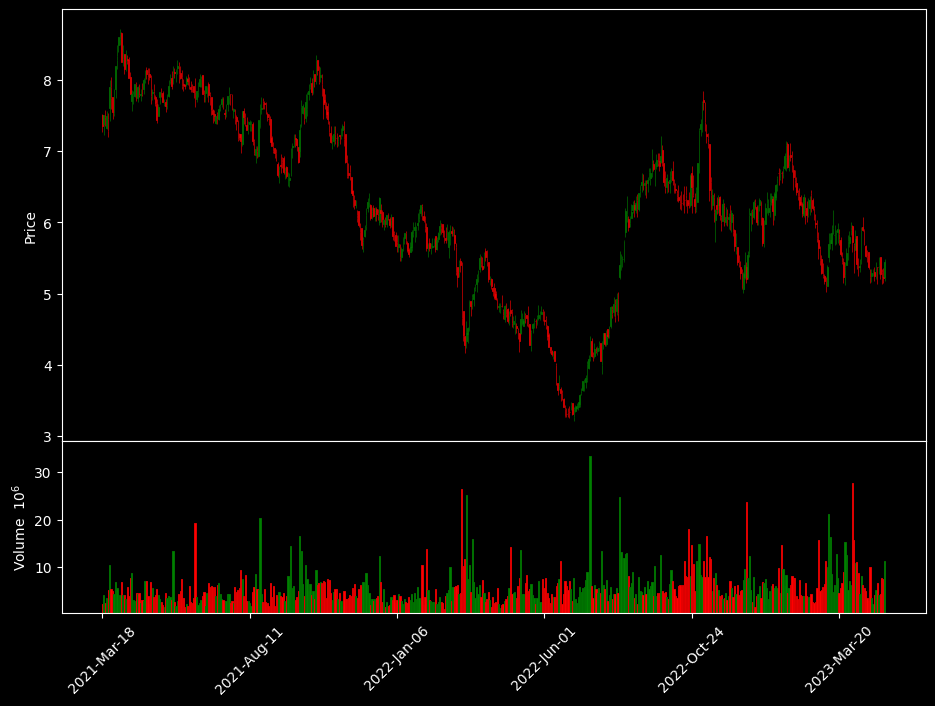

In [23]:
import mplfinance as mpf

# Customize the style of the candlestick chart
mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
s = mpf.make_mpf_style(base_mpl_style='dark_background', marketcolors=mc)

# Plotar candlesticks com mplfinance
mpf.plot(gmat3, type='candle', style=s, volume=True, figscale=1.5)

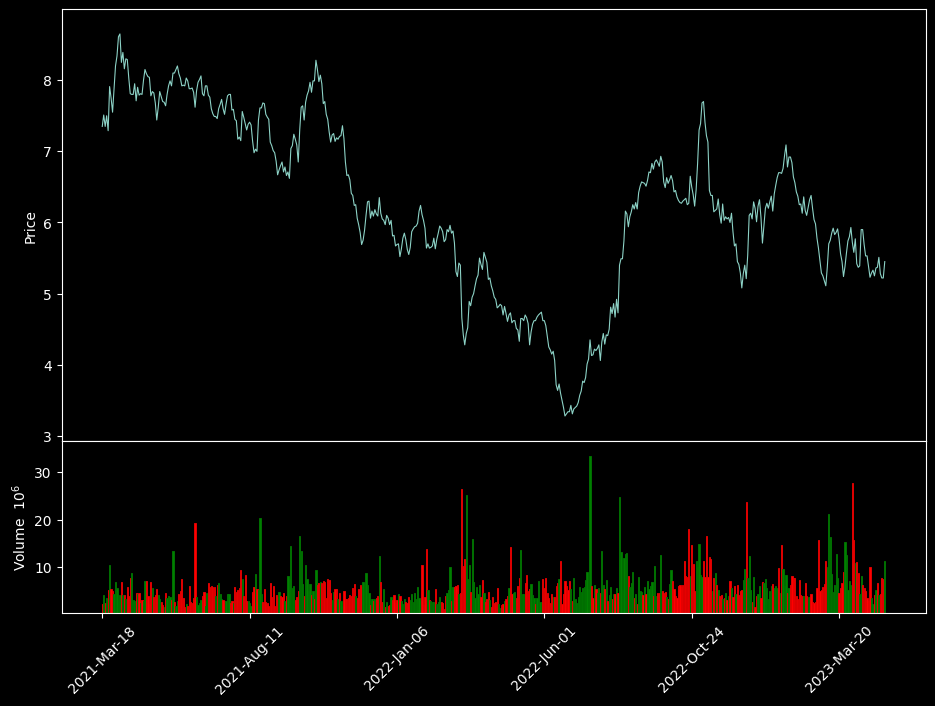

In [24]:
# Plotar candlesticks com mplfinance
mpf.plot(gmat3, type='line', style=s, volume=True, figscale=1.5)

## <a id='toc1_3_'></a>[Coleta de preço de mercado do ticker](#toc0_)

In [25]:
import yfinance as yf

# List of tickers
tickers = ['GMAT3.SA']

# Get current price for each ticker
prices = {}
for ticker in tickers:
    info = yf.Ticker(ticker).info
    if 'regularMarketPrice' in info:
        prices[ticker] = info['regularMarketPrice']
    else:
        data = yf.Ticker(ticker).history(period='1d', auto_adjust=True)
        if len(data) > 0:
            prices[ticker] = data['Close'][0]
        else:
            prices[ticker] = None

# Print prices
for ticker, price in prices.items():
    if price is not None:
        print(f'{ticker}: R${price:.2f}' if '.SA' in ticker else f'{ticker}: ${price:.2f}')
    else:
        print(f'{ticker}: N/A')


GMAT3.SA: R$7.98


# <a id='toc2_'></a>[Implementação de cálculos a partir de planilha de operações da Dlombello](#toc0_)

A planilha vem com muitos dados mal formatados. Nesta etapa é feita a formatação e salva-se em parquet.

In [26]:
import os
os.path.join(os.pardir, 'data', "raw")

'..\\data\\raw'

In [27]:
my_operations = pd.read_csv(os.path.join(os.pardir, 'data', "raw", "operações.CSV"), sep=';', decimal=',', encoding='CP1252')

In [28]:
my_operations.head()

,ativo,date,tipoOP,qtd,preco,taxas,corretora,irrf,moeda,classe,...,qtdAtual,pmAtual,qtdAnt,pmAnt,vlrInvest,fluxoCx,date_ini,pmAtual_usd,pmAtual_ptax,lucro_pct
0,BRDT3,18/07/2019,C,38.0,26.35,3.61,MODAL,0.0,BRL,AÇÃO,...,38.0,"26,45",0.0,"0,00","1.004,91","-1.004,91",18/07/2019,26.45,1.0,NaN
1,LAME4,18/07/2019,C,35.0,17.48,2.20,MODAL,0.0,BRL,AÇÃO,...,35.0,"17,54",0.0,"0,00","614,00","-614,00",18/07/2019,17.54,1.0,NaN
2,BRDT3,23/07/2019,V,-38.0,25.94,4.42,MODAL,0.0,BRL,AÇÃO,...,0.0,"0,00",38.0,"26,45","-1.004,91","981,30",NaN,0.00,0.0,"-2,35%"
3,ITSA4,23/07/2019,C,25.0,13.29,1.49,MODAL,0.0,BRL,AÇÃO,...,25.0,"13,35",0.0,"0,00","333,74","-333,74",23/07/2019,13.35,1.0,NaN
4,LAME4,23/07/2019,V,-35.0,16.78,2.64,MODAL,0.0,BRL,AÇÃO,...,0.0,"0,00",35.0,"17,54","-614,00","584,66",NaN,0.00,0.0,"-4,78%"


In [29]:
my_operations['lucro_pct'] = my_operations['lucro_pct'].fillna('0').apply(lambda x: x.replace(',','.').replace('%','')).astype(float)

In [30]:
my_operations['fluxoCx'] = my_operations['fluxoCx'].apply(lambda x: x.replace('.','').replace(',','.')).astype(float)

In [31]:
my_operations['vlrInvest'] = my_operations['vlrInvest'].apply(lambda x: x.replace('.','').replace(',','.')).astype(float)

In [32]:
my_operations['pmAnt'] = my_operations['pmAnt'].apply(lambda x: x.replace('.','').replace(',','.')).astype(float)
my_operations['pmAtual'] = my_operations['pmAtual'].apply(lambda x: x.replace('.','').replace(',','.')).astype(float)

In [33]:
my_operations['vol'] = my_operations['vol'].apply(lambda x: x.replace('.','').replace(',','.')).astype(float)

In [34]:
my_operations['lucro'] = my_operations['lucro'].apply(lambda x: x.replace('.','').replace(',','.')).astype(float)

In [35]:
from pytz import timezone
my_operations['date'] = pd.to_datetime(my_operations['date'], dayfirst=True)
my_operations['date'] = pd.to_datetime(my_operations['date']).dt.tz_localize(timezone('America/Sao_Paulo'))

In [36]:
def forward_fill_on_date_ini(df):
    df['date_ini'] = df['date_ini'].fillna(method='ffill')
    df['date_ini'] = pd.to_datetime(df['date_ini'], dayfirst=True)
    return df

In [37]:
my_operations = my_operations.groupby('ativo').apply(forward_fill_on_date_ini).reset_index(drop=True)
my_operations = my_operations.sort_values(by=['date'])

In [38]:
my_operations.dtypes

ativo                                      object
date            datetime64[ns, America/Sao_Paulo]
tipoOP                                     object
qtd                                       float64
preco                                     float64
taxas                                     float64
corretora                                  object
irrf                                      float64
moeda                                      object
classe                                     object
ptax                                      float64
vol                                       float64
lucro                                     float64
qtdAtual                                  float64
pmAtual                                   float64
qtdAnt                                    float64
pmAnt                                     float64
vlrInvest                                 float64
fluxoCx                                   float64
date_ini                           datetime64[ns]


In [39]:
my_operations.to_parquet(os.path.join(os.pardir, 'data', "interim", "operações.parquet"))

## <a id='toc2_1_'></a>[Salva dados da planilha em parquet](#toc0_)

In [40]:
my_operations = pd.read_parquet(os.path.join(os.pardir, 'data', "interim", "operações.parquet"))

In [41]:
my_operations.head()

,ativo,date,tipoOP,qtd,preco,taxas,corretora,irrf,moeda,classe,...,qtdAtual,pmAtual,qtdAnt,pmAnt,vlrInvest,fluxoCx,date_ini,pmAtual_usd,pmAtual_ptax,lucro_pct
244,LAME4,2019-07-18 00:00:00-03:00,C,35.0,17.48,2.20,MODAL,0.0,BRL,AÇÃO,...,35.0,17.54,0.0,0.00,614.00,-614.00,2019-07-18,17.54,1.0,0.00
75,BRDT3,2019-07-18 00:00:00-03:00,C,38.0,26.35,3.61,MODAL,0.0,BRL,AÇÃO,...,38.0,26.45,0.0,0.00,1004.91,-1004.91,2019-07-18,26.45,1.0,0.00
245,LAME4,2019-07-23 00:00:00-03:00,V,-35.0,16.78,2.64,MODAL,0.0,BRL,AÇÃO,...,0.0,0.00,35.0,17.54,-614.00,584.66,2019-07-18,0.00,0.0,-4.78
205,ITSA4,2019-07-23 00:00:00-03:00,C,25.0,13.29,1.49,MODAL,0.0,BRL,AÇÃO,...,25.0,13.35,0.0,0.00,333.74,-333.74,2019-07-23,13.35,1.0,0.00
76,BRDT3,2019-07-23 00:00:00-03:00,V,-38.0,25.94,4.42,MODAL,0.0,BRL,AÇÃO,...,0.0,0.00,38.0,26.45,-1004.91,981.30,2019-07-18,0.00,0.0,-2.35


In [42]:
gmat3_ops = my_operations[my_operations['ativo'] == 'GMAT3']

In [43]:
gmat3_ops

,ativo,date,tipoOP,qtd,preco,taxas,corretora,irrf,moeda,classe,...,qtdAtual,pmAtual,qtdAnt,pmAnt,vlrInvest,fluxoCx,date_ini,pmAtual_usd,pmAtual_ptax,lucro_pct
162,GMAT3,2021-03-18 00:00:00-03:00,C,67.0,7.48,0.14,CLEAR,0.0,BRL,AÇÃO,...,67.0,7.48,0.0,0.00,501.30,-501.30,2021-03-18,7.48,1.0,0.0
163,GMAT3,2021-05-04 00:00:00-03:00,C,19.0,8.15,0.05,CLEAR,0.0,BRL,AÇÃO,...,86.0,7.63,67.0,7.48,154.90,-154.90,2021-03-18,7.63,1.0,0.0
164,GMAT3,2021-05-12 00:00:00-03:00,C,10.0,7.46,0.02,CLEAR,0.0,BRL,AÇÃO,...,96.0,7.61,86.0,7.63,74.62,-74.62,2021-03-18,7.61,1.0,0.0
165,GMAT3,2021-08-13 00:00:00-03:00,C,17.0,7.14,0.04,CLEAR,0.0,BRL,AÇÃO,...,113.0,7.54,96.0,7.61,121.42,-121.42,2021-03-18,7.54,1.0,0.0
166,GMAT3,2021-08-18 00:00:00-03:00,C,22.0,7.04,0.05,CLEAR,0.0,BRL,AÇÃO,...,135.0,7.46,113.0,7.54,154.93,-154.93,2021-03-18,7.46,1.0,0.0
167,GMAT3,2021-11-22 00:00:00-03:00,C,11.0,6.45,0.02,CLEAR,0.0,BRL,AÇÃO,...,146.0,7.38,135.0,7.46,70.97,-70.97,2021-03-18,7.38,1.0,0.0
168,GMAT3,2022-08-05 00:00:00-03:00,C,63.0,4.83,0.09,CLEAR,0.0,BRL,AÇÃO,...,209.0,6.61,146.0,7.38,304.38,-304.38,2021-03-18,6.61,1.0,0.0
169,GMAT3,2023-03-08 00:00:00-03:00,C,53.0,5.37,0.09,CLEAR,0.0,BRL,AÇÃO,...,262.0,6.36,209.0,6.61,284.70,-284.70,2021-03-18,6.36,1.0,0.0


In [44]:
abcb4_ops = my_operations[my_operations['ativo'] == 'ABCB4']

In [45]:
abcb4_ops

,ativo,date,tipoOP,qtd,preco,taxas,corretora,irrf,moeda,classe,...,qtdAtual,pmAtual,qtdAnt,pmAnt,vlrInvest,fluxoCx,date_ini,pmAtual_usd,pmAtual_ptax,lucro_pct
0,ABCB4,2020-01-29 00:00:00-03:00,C,4.0,22.36,0.01,CLEAR,0.0,BRL,AÇÃO,...,4.0,22.36,0.0,0.00,89.45,-89.45,2020-01-29,22.36,1.0,0.00
1,ABCB4,2020-01-30 00:00:00-03:00,C,16.0,21.74,0.10,CLEAR,0.0,BRL,AÇÃO,...,20.0,21.87,4.0,22.36,347.94,-347.94,2020-01-29,21.87,1.0,0.00
2,ABCB4,2020-03-02 00:00:00-03:00,C,1.0,20.25,0.00,CLEAR,0.0,BRL,AÇÃO,...,21.0,21.79,20.0,21.87,20.25,-20.25,2020-01-29,21.79,1.0,0.00
3,ABCB4,2020-03-31 00:00:00-03:00,C,13.0,13.54,0.05,CLEAR,0.0,BRL,AÇÃO,...,34.0,18.64,21.0,21.79,176.07,-176.07,2020-01-29,18.64,1.0,0.00
4,ABCB4,2020-03-31 00:00:00-03:00,C,9.0,13.57,0.05,CLEAR,0.0,BRL,AÇÃO,...,43.0,17.58,34.0,18.64,122.18,-122.18,2020-01-29,17.58,1.0,0.00
5,ABCB4,2020-04-09 00:00:00-03:00,C,8.0,13.64,0.04,CLEAR,0.0,BRL,AÇÃO,...,51.0,16.96,43.0,17.58,109.16,-109.16,2020-01-29,16.96,1.0,0.00
6,ABCB4,2020-08-31 00:00:00-03:00,C,25.0,13.73,0.11,CLEAR,0.0,BRL,AÇÃO,...,76.0,15.90,51.0,16.96,343.36,-343.36,2020-01-29,15.90,1.0,0.00
7,ABCB4,2020-09-29 00:00:00-03:00,V,-17.0,11.71,0.07,CLEAR,0.0,BRL,AÇÃO,...,59.0,15.90,76.0,15.90,-270.30,199.00,2020-01-29,15.90,1.0,-26.38
9,ABCB4,2020-09-29 00:00:00-03:00,V,-40.0,11.71,0.14,CLEAR,0.0,BRL,AÇÃO,...,0.0,0.00,40.0,15.90,-636.01,468.26,2020-01-29,0.00,0.0,-26.37
8,ABCB4,2020-09-29 00:00:00-03:00,V,-19.0,11.71,0.07,CLEAR,0.0,BRL,AÇÃO,...,40.0,15.90,59.0,15.90,-302.10,222.42,2020-01-29,15.90,1.0,-26.38


A ordem da última operação veio errada. Troca-se de lugar as duas.

In [46]:
last_row = abcb4_ops.iloc[-1].copy()
abcb4_ops.iloc[-1] = abcb4_ops.iloc[-2]
abcb4_ops.iloc[-2] = last_row

In [47]:
abcb4_ops

,ativo,date,tipoOP,qtd,preco,taxas,corretora,irrf,moeda,classe,...,qtdAtual,pmAtual,qtdAnt,pmAnt,vlrInvest,fluxoCx,date_ini,pmAtual_usd,pmAtual_ptax,lucro_pct
0,ABCB4,2020-01-29 00:00:00-03:00,C,4.0,22.36,0.01,CLEAR,0.0,BRL,AÇÃO,...,4.0,22.36,0.0,0.00,89.45,-89.45,2020-01-29,22.36,1.0,0.00
1,ABCB4,2020-01-30 00:00:00-03:00,C,16.0,21.74,0.10,CLEAR,0.0,BRL,AÇÃO,...,20.0,21.87,4.0,22.36,347.94,-347.94,2020-01-29,21.87,1.0,0.00
2,ABCB4,2020-03-02 00:00:00-03:00,C,1.0,20.25,0.00,CLEAR,0.0,BRL,AÇÃO,...,21.0,21.79,20.0,21.87,20.25,-20.25,2020-01-29,21.79,1.0,0.00
3,ABCB4,2020-03-31 00:00:00-03:00,C,13.0,13.54,0.05,CLEAR,0.0,BRL,AÇÃO,...,34.0,18.64,21.0,21.79,176.07,-176.07,2020-01-29,18.64,1.0,0.00
4,ABCB4,2020-03-31 00:00:00-03:00,C,9.0,13.57,0.05,CLEAR,0.0,BRL,AÇÃO,...,43.0,17.58,34.0,18.64,122.18,-122.18,2020-01-29,17.58,1.0,0.00
5,ABCB4,2020-04-09 00:00:00-03:00,C,8.0,13.64,0.04,CLEAR,0.0,BRL,AÇÃO,...,51.0,16.96,43.0,17.58,109.16,-109.16,2020-01-29,16.96,1.0,0.00
6,ABCB4,2020-08-31 00:00:00-03:00,C,25.0,13.73,0.11,CLEAR,0.0,BRL,AÇÃO,...,76.0,15.90,51.0,16.96,343.36,-343.36,2020-01-29,15.90,1.0,0.00
7,ABCB4,2020-09-29 00:00:00-03:00,V,-17.0,11.71,0.07,CLEAR,0.0,BRL,AÇÃO,...,59.0,15.90,76.0,15.90,-270.30,199.00,2020-01-29,15.90,1.0,-26.38
9,ABCB4,2020-09-29 00:00:00-03:00,V,-19.0,11.71,0.07,CLEAR,0.0,BRL,AÇÃO,...,40.0,15.90,59.0,15.90,-302.10,222.42,2020-01-29,15.90,1.0,-26.38
8,ABCB4,2020-09-29 00:00:00-03:00,V,-40.0,11.71,0.14,CLEAR,0.0,BRL,AÇÃO,...,0.0,0.00,40.0,15.90,-636.01,468.26,2020-01-29,0.00,0.0,-26.37


In [48]:
import numpy as np

## <a id='toc2_2_'></a>[Cálculos da ação](#toc0_)

Cálculos de dividendos, valor investido, lucros, preço-médio, cálculos considerando a conversão para dólar.

In [124]:
from datetime import datetime

def prepare_stock(ticker, operations):
    print(f"Building stock infos for ticker {ticker}...")
    start_date = operations["date"].min()
    end_date = datetime.now().date()

    try:
        yf_ticker = get_ticker(ticker)
    except ValueError:
        return None
    
    print(f"Searching for ticker data from {start_date} to {end_date}...")
    _ticker = yf_ticker.history(start=start_date, end=end_date)
    
    _ticker_dividends = _ticker[_ticker['Dividends'] != 0]['Dividends']
    _ticker_dividends = _ticker_dividends.reset_index()
    _ticker_dividends = pd.DataFrame(_ticker_dividends).rename(columns={'Date': 'date'})
    
    _ticker_operations = operations[operations['ativo'] == f'{ticker}']

    _ticker_splits = _ticker[_ticker['Stock Splits'] != 0]['Stock Splits']
    _ticker_splits = pd.DataFrame(_ticker_splits).rename(columns={'Date': 'date'})

    _ticker_dividends_and_ops = pd.concat([_ticker_operations, _ticker_dividends]).sort_values(by=['date']).reset_index(drop=True)

    _ticker_dividends_and_ops['tipoOP'].fillna('D', inplace=True)

    _ticker_dividends_and_ops = pd.concat([_ticker_dividends_and_ops, _ticker_splits]).sort_values(by=['date']).reset_index(drop=True)
    
    _ticker_dividends_and_ops['Stock Splits'].fillna(1, inplace=True)
    _ticker_dividends_and_ops['tipoOP'] = np.where(_ticker_dividends_and_ops['Stock Splits'] > 1, 'S', _ticker_dividends_and_ops['tipoOP'])
    _ticker_dividends_and_ops['tipoOP'] = np.where(_ticker_dividends_and_ops['Stock Splits'] < 1, 'I', _ticker_dividends_and_ops['tipoOP'])

    _ticker_dividends_and_ops['ativo'].fillna(f"{ticker}", inplace=True)
    _ticker_dividends_and_ops[['preco', 'qtd', 'lucro_pct', 'lucro', 'irrf', 'vlrInvest', 'taxas', 'Dividends']].fillna(0, inplace=True)
    _ticker_dividends_and_ops[['pmAtual', 'date_ini', 'pmAtual_usd', 'pmAtual_ptax', 'classe', 'moeda', 'qtdAtual', 'qtdAnt', 'pmAnt']].ffill(inplace=True)
    _ticker_dividends_and_ops['ptax'].fillna(1, inplace=True)

    return _ticker_dividends_and_ops
    

In [122]:
def stock_calculations(group: pd.DataFrame):
    print(f"Calculating for {group.name}...")
    stock_df = prepare_stock(group.name, group)

    if stock_df is None:
        return group

    if 'Dividends' not in stock_df.columns:
        stock_df['Dividends'] = 0

    if 'Stock Splits' not in stock_df.columns:
        stock_df['Stock Splits'] = 1

    # Stock Quantity
    stock_df['qtd_acum'] = stock_df['qtd'].cumsum()

    stock_df['qtd_acum'] = np.where(
            stock_df['qtd_acum'] < 0.0001,
            0,
            stock_df['qtd_acum']
        )
    stock_df['qtd_acum_ant'] = stock_df['qtd_acum'].shift(1).fillna(0)

    # Adjusted Stock Quantity for Stock Splits
    stock_df['adjusted_qtd_acum'] = stock_df['qtd_acum_ant']
    
    split_mask = stock_df['Stock Splits'] != 1

    stock_df.loc[split_mask, 'adjusted_qtd_acum'] += (
        (stock_df['Stock Splits'] * stock_df['qtd_acum'][split_mask]) -
        stock_df['qtd_acum'][split_mask]
    )

    # Original Currency
    invested_usd = ((stock_df['preco'] * stock_df['qtd']) + stock_df['taxas']).cumsum()
    stock_df['invested_usd'] = invested_usd
    stock_df['pm_atual_usd'] = np.where(
            (stock_df['tipoOP'] == 'V'),
            np.nan,
            invested_usd / stock_df['qtd_acum']
        )
    stock_df['pm_atual_usd'] = np.where(
            (stock_df['pm_atual_usd'] == np.inf) | (stock_df['pm_atual_usd'] == -np.inf),
            0,
            stock_df['pm_atual_usd']
        )
    stock_df['pm_atual_usd'].ffill(inplace=True)
    stock_df['pm_ant_usd'] = stock_df['pm_atual_usd'].shift(1).fillna(0)

    # Currency exchange rate considered
    # Disconsiders dividends
    stock_df['volume'] = (stock_df['qtd'] * stock_df['preco'] * stock_df['ptax'])
    
    stock_df['fluxo_cx'] = -((stock_df['preco'] * stock_df['qtd']) + stock_df['taxas']) * stock_df['ptax']
    stock_df['fluxo_cx'] = np.where(
        stock_df['tipoOP'] == 'D',
        stock_df['Dividends'] * stock_df['ptax'] * stock_df['qtd_acum'],
        stock_df['fluxo_cx']
    )

    invested = ( ((stock_df['preco'] * stock_df['qtd']) + stock_df['taxas']) * stock_df['ptax']).cumsum()
    stock_df['invested'] = invested
    stock_df['pm_atual'] = np.where(
            (stock_df['tipoOP'] == 'V'),
            np.nan,
            invested / stock_df['qtd_acum']
        )
    stock_df['pm_atual'] = np.where(
            (stock_df['pm_atual'] == np.inf) | (stock_df['pm_atual'] == -np.inf),
            0,
            stock_df['pm_atual']
        )
    stock_df['pm_atual'].ffill(inplace=True)
    stock_df['pm_ant'] = stock_df['pm_atual'].shift(1).fillna(0)

    stock_df['profits'] = np.where(
        (stock_df['tipoOP'] == 'V') & (stock_df['pm_atual'] > 0.0),
        -(stock_df['qtd'] * (((stock_df['preco'] - stock_df['taxas']) * stock_df['ptax']) - stock_df['pm_ant'])),
        np.where(
            (stock_df['tipoOP'] == 'V') & (stock_df['pm_atual'] <= 0.0),
            (stock_df['qtd'] * np.abs(((stock_df['preco'] - stock_df['taxas']) * stock_df['ptax']) - stock_df['pm_ant'])),
            0
        )
    )
    stock_df['profits_pct'] = np.where(
        (stock_df['tipoOP'] == 'V') & (stock_df['pm_atual'] > 0.0),
        ((((stock_df['preco'] - stock_df['taxas']) * stock_df['ptax']) - stock_df['pm_ant'])/stock_df['pm_ant']) * 100,
        np.where(
            (stock_df['tipoOP'] == 'V') & (stock_df['pm_atual'] <= 0.0),
            (( ((stock_df['preco'] - stock_df['taxas']) * stock_df['ptax']) - stock_df['pm_ant'])/ stock_df['pm_ant'])*100,
            0
            )
        )
    
    # Considers dividends
    invested_adjusted = ( ( ( (stock_df['preco'] * stock_df['qtd']) + stock_df['taxas'] ) - (stock_df['Dividends'] * stock_df['qtd_acum']) ) * stock_df['ptax']).cumsum()
    stock_df['invested_adjusted'] = invested_adjusted

    stock_df['pm_atual_adjusted'] = np.where(
        (stock_df['tipoOP'] == 'V'),
        np.nan,
        invested_adjusted / stock_df['qtd_acum']
    )

    stock_df['pm_atual_adjusted'] = np.where(
        (stock_df['pm_atual_adjusted'] == np.inf) | (stock_df['pm_atual_adjusted'] == -np.inf),
        0,
        stock_df['pm_atual_adjusted']
    )

    stock_df['pm_atual_adjusted'].ffill(inplace=True)
    stock_df['pm_ant_adjusted'] = stock_df['pm_atual_adjusted'].shift(1).fillna(0)
    
    stock_df['profits_adjusted'] = np.where(
        (stock_df['tipoOP'] == 'V') & (stock_df['pm_atual_adjusted'] > 0.0),
        -(stock_df['qtd'] * (((stock_df['preco'] - stock_df['taxas']) * stock_df['ptax']) - stock_df['pm_ant_adjusted'])),
        np.where(
            (stock_df['tipoOP'] == 'V') & (stock_df['pm_atual_adjusted'] <= 0.0),
            (stock_df['qtd'] * np.abs(((stock_df['preco'] - stock_df['taxas']) * stock_df['ptax']) - stock_df['pm_ant_adjusted'])),
            0
        )
    )
    stock_df['profits_adjusted_pct'] = np.where(
        (stock_df['tipoOP'] == 'V') & (stock_df['pm_atual_adjusted'] > 0.0),
        ( ( ((stock_df['preco'] - stock_df['taxas']) * stock_df['ptax']) - stock_df['pm_ant_adjusted'])/stock_df['pm_ant_adjusted'])*100,
        np.where(
            (stock_df['tipoOP'] == 'V') & (stock_df['pm_atual_adjusted'] <= 0.0),
            ((((stock_df['preco'] - stock_df['taxas']) * stock_df['ptax']) - stock_df['pm_ant_adjusted'])/ stock_df['pm_ant_adjusted'])*100,
            0
        )
    )
    return stock_df


In [125]:
my_operations.groupby('ativo').apply(stock_calculations)

Calculating for ABCB4...
Building stock infos for ticker ABCB4...
ABCB4 is in SA market
Requesting ticker info...
Calculating for ABEV3...
Building stock infos for ticker ABEV3...
ABEV3 is in SA market
Requesting ticker info...
Calculating for ALUP11...
Building stock infos for ticker ALUP11...
ALUP11 is in SA market
Requesting ticker info...
Calculating for ALZR11...
Building stock infos for ticker ALZR11...
ALZR11 is in SA market
Requesting ticker info...
Calculating for AMAR3...
Building stock infos for ticker AMAR3...
AMAR3 is in SA market
Requesting ticker info...
Calculating for AMZN...
Building stock infos for ticker AMZN...
AMZN is in US market
Requesting ticker info...
Calculating for B3SA3...
Building stock infos for ticker B3SA3...
B3SA3 is in SA market
Requesting ticker info...
Calculating for BABA34...
Building stock infos for ticker BABA34...
BABA34 is in SA market
Requesting ticker info...
Calculating for BBDC4...
Building stock infos for ticker BBDC4...
BBDC4 is in SA m

BRML3.SA: No timezone found, symbol may be delisted


KeyError: 'Dividends'

In [50]:
abcb4_dividends = abcb4[abcb4['Dividends'] != 0]['Dividends']

In [51]:
abcb4_dividends = abcb4_dividends.reset_index()

In [52]:
abcb4_dividends = pd.DataFrame(abcb4_dividends).rename(columns={'Date': 'date'})

In [53]:
abcb4_dividends_and_ops = pd.concat([abcb4_ops, abcb4_dividends]).sort_values(by=['date'])

Isso é realizado somente para visualização da planilha importada da dlombello.

In [54]:
abcb4_dividends_and_ops['ativo'].fillna('ABCB4', inplace=True)
abcb4_dividends_and_ops['tipoOP'].fillna('D', inplace=True)
abcb4_dividends_and_ops[['preco', 'qtd', 'lucro_pct', 'lucro', 'irrf', 'vlrInvest', 'taxas', 'Dividends']].fillna(0, inplace=True)
abcb4_dividends_and_ops[['pmAtual', 'date_ini', 'pmAtual_usd', 'pmAtual_ptax', 'classe', 'moeda', 'qtdAtual', 'qtdAnt', 'pmAnt']].ffill(inplace=True)
abcb4_dividends_and_ops['ptax'].fillna(1, inplace=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_16168\2814374692.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abcb4_dividends_and_ops[['preco', 'qtd', 'lucro_pct', 'lucro', 'irrf', 'vlrInvest', 'taxas', 'Dividends']].fillna(0, inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_16168\2814374692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abcb4_dividends_and_ops[['pmAtual', 'date_ini', 'pmAtual_usd', 'pmAtual_ptax', 'classe', 'moeda', 'qtdAtual', 'qtdAnt', 'pmAnt']].ffill(inplace=True)


In [55]:
abcb4_dividends_and_ops.reset_index(inplace=True, drop=True)

In [56]:
abcb4_dividends_and_ops.groupby('ativo').apply(stock_calculations)[['preco', 'invested', 'invested_adjusted', 'qtd', 'volume', 'profits', 'profits_adjusted', 'lucro', 'qtd_acum', 'pm_atual', 'pm_atual_adjusted', 'pmAtual', 'qtd_acum_ant', 'pm_ant', 'profits_pct', 'profits_adjusted_pct', 'lucro_pct', 'fluxoCx', 'fluxo_cx', 'Dividends']]

preco  invested  invested_adjusted   qtd  volume     profits  \
ativo                                                                    
ABCB4 0   22.36     89.45                NaN   4.0   89.44    0.000000   
      1   21.74    437.39                NaN  16.0  347.84    0.000000   
      2   20.25    457.64                NaN   1.0   20.25    0.000000   
      3   13.54    633.71                NaN  13.0  176.02    0.000000   
      4   13.57    755.89                NaN   9.0  122.13    0.000000   
      5   13.64    865.05                NaN   8.0  109.12    0.000000   
      6     NaN       NaN                NaN   NaN     NaN    0.000000   
      7   13.73   1208.41                NaN  25.0  343.25    0.000000   
      8   11.71   1009.41                NaN -17.0 -199.07  -72.422237   
      9   11.71    786.99                NaN -19.0 -222.49  -80.942500   
      10  11.71    318.73                NaN -40.0 -468.40 -173.205263   

          profits_adjusted   lucro  qtd_acum   pm_atual  pm_atual_adjusted  \
ativo                                                                        
ABCB4 0                0.0    0.00       4.0  22.362500                NaN   
      1                0.0    0.00      20.0  21.869500                NaN   
      2                0.0    0.00      21.0  21.792381                NaN   
      3                0.0    0.00      34.0  18.638529                NaN   
      4                0.0    0.00      43.0  17.578837                NaN   
      5                0.0    0.00      51.0  16.961765                NaN   
      6                0.0     NaN       NaN  16.961765                NaN   
      7                0.0    0.00      76.0  15.900132                NaN   
      8                0.0  -71.30      59.0  15.900132                NaN   
      9                0.0  -79.68      40.0  15.900132                NaN   
      10               0.0 -167.75       0.0  15.900132                NaN   

          pmAtual  qtd_acum_ant     pm_ant  profits_pct  profits_adjusted_pct  \
ativo                                                                           
ABCB4 0     22.36           0.0   0.000000     0.000000                   0.0   
      1     21.87           4.0  22.362500     0.000000                   0.0   
      2     21.79          20.0  21.869500     0.000000                   0.0   
      3     18.64          21.0  21.792381     0.000000                   0.0   
      4     17.58          34.0  18.638529     0.000000                   0.0   
      5     16.96          43.0  17.578837     0.000000                   0.0   
      6       NaN          51.0  16.961765     0.000000                   0.0   
      7     15.90           0.0  16.961765     0.000000                   0.0   
      8     15.90          76.0  15.900132   -26.793059                   0.0   
      9     15.90          59.0  15.900132   -26.793059                   0.0   
      10     0.00          40.0  15.900132   -27.233307                   0.0   

          lucro_pct  fluxoCx  fluxo_cx  Dividends  
ativo                                              
ABCB4 0        0.00   -89.45    -89.45        NaN  
      1        0.00  -347.94   -347.94        NaN  
      2        0.00   -20.25    -20.25        NaN  
      3        0.00  -176.07   -176.07        NaN  
      4        0.00  -122.18   -122.18        NaN  
      5        0.00  -109.16   -109.16        NaN  
      6         NaN      NaN       NaN   0.157723  
      7        0.00  -343.36   -343.36        NaN  
      8      -26.38   199.00    199.00        NaN  
      9      -26.38   222.42    222.42        NaN  
      10     -26.37   468.26    468.26        NaN

Para ações brasileiras sem inplit e split, os cálculos já estão funcionais nesse momento.

In [57]:
bacb4_calculated = abcb4_dividends_and_ops.groupby('ativo').apply(stock_calculations)

# <a id='toc3_'></a>[Teste de ações estrangeiras](#toc0_)

In [58]:
huya = yf.Ticker("HUYA", session=session).history(start="2021-08-19", end="2022-10-14")

In [59]:
huya_dividends = huya[huya['Dividends'] != 0]['Dividends']

In [60]:
huya_dividends = huya_dividends

In [61]:
huya_dividends = pd.DataFrame(huya_dividends.reset_index()).rename(columns={'Date': 'date'})

In [62]:
huya_ops = my_operations[my_operations['ativo'] == 'HUYA']

In [63]:
huya_ops

,ativo,date,tipoOP,qtd,preco,taxas,corretora,irrf,moeda,classe,...,qtdAtual,pmAtual,qtdAnt,pmAnt,vlrInvest,fluxoCx,date_ini,pmAtual_usd,pmAtual_ptax,lucro_pct
188,HUYA,2021-08-19 00:00:00-03:00,C,17.97059,9.4599,4.144642,AVENUE,0.0,USD,STOCK,...,20.56044,52.50,2.58985,52.50,943.52,-943.52,2021-08-19,9.69,5.418000,0.00
187,HUYA,2021-08-19 00:00:00-03:00,C,2.58985,9.4600,0.597316,AVENUE,0.0,USD,STOCK,...,2.58985,52.50,0.00000,0.00,135.98,-135.98,2021-08-19,9.69,5.418000,0.00
189,HUYA,2021-11-03 00:00:00-03:00,C,1.46072,8.8997,0.316943,AVENUE,0.0,USD,STOCK,...,22.02116,52.45,20.56044,52.50,75.47,-75.47,2021-08-19,9.65,5.433612,0.00
190,HUYA,2021-11-03 00:00:00-03:00,C,3.36734,8.9091,0.731407,AVENUE,0.0,USD,STOCK,...,25.38850,52.35,22.02116,52.45,174.16,-174.16,2021-08-19,9.58,5.463118,0.00
192,HUYA,2022-01-11 00:00:00-03:00,C,4.25833,7.0450,0.000000,AVENUE,0.0,USD,STOCK,...,33.91122,49.16,29.65289,50.52,169.05,-169.05,2021-08-19,8.94,5.497141,0.00
191,HUYA,2022-01-11 00:00:00-03:00,C,4.26439,7.0350,0.000000,AVENUE,0.0,USD,STOCK,...,29.65289,50.52,25.38850,52.35,169.05,-169.05,2021-08-19,9.22,5.481997,0.00
193,HUYA,2022-10-14 00:00:00-03:00,V,-33.91122,2.1301,0.000000,AVENUE,0.0,USD,STOCK,...,0.00000,49.16,33.91122,49.16,-1667.23,381.53,2021-08-19,8.94,5.497141,-77.12


In [64]:
huya_dividends_and_ops = pd.concat([huya_ops, huya_dividends]).sort_values(by=['date'])

In [65]:
huya_dividends_and_ops['ativo'].fillna('HUYA', inplace=True)
huya_dividends_and_ops['tipoOP'].fillna('D', inplace=True)
huya_dividends_and_ops['preco'].fillna(0, inplace=True)
huya_dividends_and_ops['qtd'].fillna(0, inplace=True)
huya_dividends_and_ops['lucro_pct'].fillna(0, inplace=True)
huya_dividends_and_ops['pmAtual'].ffill(inplace=True)
huya_dividends_and_ops['lucro'].fillna(0, inplace=True)
huya_dividends_and_ops['date_ini'].ffill(inplace=True)
huya_dividends_and_ops['pmAtual_usd'].ffill(inplace=True)
huya_dividends_and_ops['pmAtual_ptax'].ffill(inplace=True)
huya_dividends_and_ops['classe'].ffill(inplace=True)
huya_dividends_and_ops['moeda'].ffill(inplace=True)
huya_dividends_and_ops['irrf'].fillna(0, inplace=True)
huya_dividends_and_ops['vlrInvest'].fillna(0, inplace=True)
huya_dividends_and_ops['taxas'].fillna(0, inplace=True)
huya_dividends_and_ops['qtdAtual'].ffill(inplace=True)
huya_dividends_and_ops['qtdAnt'].ffill(inplace=True)
huya_dividends_and_ops['pmAnt'].ffill(inplace=True)
huya_dividends_and_ops['Dividends'].fillna(0, inplace=True)

In [66]:
huya_dividends_and_ops.groupby('ativo').apply(stock_calculations)[['preco', 'invested', 'invested_adjusted', 'qtd', 'volume', 'vol', 'profits', 'profits_adjusted', 'lucro', 'qtd_acum', 'pm_atual', 'pm_atual_adjusted', 'pmAtual', 'pm_atual_usd', 'fluxoCx', 'fluxo_cx', 'pmAtual_usd', 'qtd_acum_ant', 'pm_ant', 'profits_pct', 'profits_adjusted_pct', 'lucro_pct', 'Dividends']]

preco     invested  invested_adjusted       qtd      volume  \
ativo                                                                     
HUYA  188  9.4599   943.515586         943.515586  17.97059  921.059915   
      187  9.4600  1079.492739        1079.492739   2.58985  132.740897   
      189  8.8997  1154.962345        1154.962345   1.46072   73.673429   
      190  8.9091  1329.123196        1329.123196   3.36734  170.015823   
      192  7.0450  1498.175829        1498.175829   4.25833  169.052633   
      191  7.0350  1667.228737        1667.228737   4.26439  169.052908   
      193  2.1301  1285.701665        1285.701665 -33.91122 -381.527071   

              vol      profits  profits_adjusted   lucro  qtd_acum  ...  \
ativo                                                               ...   
HUYA  188  921.06     0.000000          0.000000     0.0  17.97059  ...   
      187  132.74     0.000000          0.000000     0.0  20.56044  ...   
      189   73.67     0.000000          0.000000     0.0  22.02116  ...   
      190  170.02     0.000000          0.000000     0.0  25.38850  ...   
      192  169.05     0.000000          0.000000     0.0  29.64683  ...   
      191  169.05     0.000000          0.000000     0.0  33.91122  ...   
      193 -381.53 -1285.701665      -1285.701665 -1285.7   0.00000  ...   

           pm_atual_usd  fluxoCx    fluxo_cx  pmAtual_usd  qtd_acum_ant  \
ativo                                                                     
HUYA  188      9.690535  -943.52 -943.515586         9.69       0.00000   
      187      9.690548  -135.98 -135.977153         9.69      17.97059   
      189      9.652481   -75.47  -75.469605         9.65      20.56044   
      190      9.582693  -174.16 -174.160851         9.58      22.02116   
      192      9.218191  -169.05 -169.052633         8.94      25.38850   
      191      8.943651  -169.05 -169.052908         9.22      29.64683   
      193      8.943651   381.53  381.527071         8.94      33.91122   

              pm_ant  profits_pct  profits_adjusted_pct  lucro_pct  Dividends  
ativo                                                                          
HUYA  188   0.000000     0.000000              0.000000       0.00        0.0  
      187  52.503317     0.000000              0.000000       0.00        0.0  
      189  52.503387     0.000000              0.000000       0.00        0.0  
      190  52.447843     0.000000              0.000000       0.00        0.0  
      192  52.351387     0.000000              0.000000       0.00        0.0  
      191  50.534099     0.000000              0.000000       0.00        0.0  
      193  49.164517   -77.116093            -77.116093     -77.12        0.0  

[7 rows x 23 columns]

Aqui percebe-se que para ações estrangeiras desconsiderando a obtenção dos valores ptax, os cálculos já estão funcionais

# <a id='toc4_'></a>[Teste de ações estrangeiras com dividendos](#toc0_)

In [67]:
cepu = yf.Ticker("CEPU", session=session).history(start="2021-06-24", end="2023-05-07")

In [68]:
cepu_dividends = cepu[cepu['Dividends'] != 0]['Dividends']

In [69]:
cepu_dividends = cepu_dividends.reset_index()

In [70]:
cepu_dividends = pd.DataFrame(cepu_dividends).rename(columns={'Date': 'date'})

In [71]:
cepu_ops = my_operations[my_operations['ativo'] == 'CEPU']

## <a id='toc4_1_'></a>[Importação de cotações do dólar do Banco Central](#toc0_)

In [72]:
import pandas as pd
import requests

# Definir a data inicial e final do período desejado
data_inicio = "06-24-2021"
data_fim = "05-07-2023"

# Enviar solicitação para a API do Banco Central
url = f"https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial='{data_inicio}'&@dataFinalCotacao='{data_fim}'&$format=json&$select=cotacaoCompra,cotacaoVenda,dataHoraCotacao"
response = requests.get(url)
response.raise_for_status()

json = response.json()


In [73]:
# Formatrar dados retornados
usd_brl = pd.DataFrame(json['value'])
usd_brl['dataHoraCotacao'] = pd.to_datetime(usd_brl['dataHoraCotacao'])
usd_brl['dataHoraCotacao'] = pd.to_datetime(usd_brl['dataHoraCotacao'].dt.tz_localize(timezone('America/Sao_Paulo')))
usd_brl['dataHoraCotacaoNY'] = pd.to_datetime(usd_brl['dataHoraCotacao'].dt.tz_convert(timezone('America/New_York')))
usd_brl['dateNY'] = pd.to_datetime(usd_brl['dataHoraCotacaoNY'].dt.date)
# usd_brl['dataHoraCotacao'] = pd.to_datetime(usd_brl['dataHoraCotacao'].dt.date)

In [74]:
usd_brl.dtypes

cotacaoCompra                                  float64
cotacaoVenda                                   float64
dataHoraCotacao      datetime64[ns, America/Sao_Paulo]
dataHoraCotacaoNY     datetime64[ns, America/New_York]
dateNY                                  datetime64[ns]
dtype: object

In [75]:
usd_brl.head()

,cotacaoCompra,cotacaoVenda,dataHoraCotacao,dataHoraCotacaoNY,dateNY
0,4.9271,4.9277,2021-06-24 13:11:26.580000-03:00,2021-06-24 12:11:26.580000-04:00,2021-06-24
1,4.9200,4.9206,2021-06-25 13:05:48.514000-03:00,2021-06-25 12:05:48.514000-04:00,2021-06-25
2,4.9414,4.9420,2021-06-28 13:06:23.426000-03:00,2021-06-28 12:06:23.426000-04:00,2021-06-28
3,4.9444,4.9450,2021-06-29 13:03:53.546000-03:00,2021-06-29 12:03:53.546000-04:00,2021-06-29
4,5.0016,5.0022,2021-06-30 13:06:37.168000-03:00,2021-06-30 12:06:37.168000-04:00,2021-06-30


In [76]:
usd_brl[usd_brl['dateNY'] == pd.to_datetime('2022-12-30')]

,cotacaoCompra,cotacaoVenda,dataHoraCotacao,dataHoraCotacaoNY,dateNY
383,5.2171,5.2177,2022-12-30 10:05:02.267000-03:00,2022-12-30 08:05:02.267000-05:00,2022-12-30


No dia da compra se pega o valor de VENDA

No dia da venda se pega o valor de COMPRA

Dividendos se considera a COMPRA

In [77]:
cepu_dividends['dateNY'] = pd.to_datetime(cepu_dividends['date'].dt.date)

In [78]:
cepu_dividends

,date,Dividends,dateNY
0,2022-12-30 00:00:00-05:00,0.165,2022-12-30


In [79]:
cepu_ops['dateNY'] = pd.to_datetime(cepu_ops['date'].dt.date)

C:\Users\arthu\AppData\Local\Temp\ipykernel_16168\2409499972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cepu_ops['dateNY'] = pd.to_datetime(cepu_ops['date'].dt.date)


### <a id='toc4_1_1_'></a>[Identificação de PTAX para as operações](#toc0_)

In [80]:
cepu_ops_with_ptax = pd.merge(cepu_ops, usd_brl[['cotacaoCompra', 'dateNY']], on='dateNY')
cepu_ops_with_ptax['ptax'] = cepu_ops_with_ptax['cotacaoCompra']
cepu_ops_with_ptax.drop(['dateNY', 'cotacaoCompra'], axis=1, inplace=True)

In [81]:
cepu_dividends_with_ptax = pd.merge(cepu_dividends, usd_brl[['cotacaoCompra', 'dateNY']], on='dateNY')
cepu_dividends_with_ptax['ptax'] = cepu_dividends_with_ptax['cotacaoCompra']
cepu_dividends_with_ptax.drop(['dateNY', 'cotacaoCompra'], axis=1, inplace=True)

In [82]:
cepu_dividends_and_ops = pd.concat([cepu_ops_with_ptax, cepu_dividends_with_ptax]).sort_values(by=['date'])

In [83]:
cepu_dividends_and_ops

,ativo,date,tipoOP,qtd,preco,taxas,corretora,irrf,moeda,classe,...,pmAtual,qtdAnt,pmAnt,vlrInvest,fluxoCx,date_ini,pmAtual_usd,pmAtual_ptax,lucro_pct,Dividends
0,CEPU,2021-06-24 00:00:00-03:00,C,115.0,2.5400,8.621471,AVENUE,0.0,USD,STOCK,...,12.89,0.0,0.00,1481.87,-1481.87,2021-06-24,2.61,4.9277,0.00,NaN
1,CEPU,2021-10-27 00:00:00-03:00,V,-20.0,4.2601,0.000000,AVENUE,0.0,USD,STOCK,...,12.89,115.0,12.89,-257.72,474.24,2021-06-24,2.61,4.9277,84.02,NaN
0,NaN,2022-12-30 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,0.165


In [84]:
cepu_dividends_and_ops['ativo'].fillna('CEPU', inplace=True)
cepu_dividends_and_ops['tipoOP'].fillna('D', inplace=True)
cepu_dividends_and_ops['preco'].fillna(0, inplace=True)
cepu_dividends_and_ops['qtd'].fillna(0, inplace=True)
cepu_dividends_and_ops['lucro_pct'].fillna(0, inplace=True)
cepu_dividends_and_ops['pmAtual'].ffill(inplace=True)
cepu_dividends_and_ops['lucro'].fillna(0, inplace=True)
cepu_dividends_and_ops['date_ini'].ffill(inplace=True)
cepu_dividends_and_ops['pmAtual_usd'].ffill(inplace=True)
cepu_dividends_and_ops['pmAtual_ptax'].ffill(inplace=True)
cepu_dividends_and_ops['classe'].ffill(inplace=True)
cepu_dividends_and_ops['moeda'].ffill(inplace=True)
cepu_dividends_and_ops['irrf'].fillna(0, inplace=True)
cepu_dividends_and_ops['vlrInvest'].fillna(0, inplace=True)
cepu_dividends_and_ops['taxas'].fillna(0, inplace=True)
cepu_dividends_and_ops['qtdAtual'].ffill(inplace=True)
cepu_dividends_and_ops['qtdAnt'].ffill(inplace=True)
cepu_dividends_and_ops['pmAnt'].ffill(inplace=True)
cepu_dividends_and_ops['Dividends'].fillna(0, inplace=True)

In [85]:
cepu_dividends_and_ops.reset_index(inplace=True, drop=True)

In [86]:
cepu_dividends_and_ops.groupby('ativo').apply(stock_calculations)[['preco', 'invested_adjusted', 'qtd', 'profits', 'profits_adjusted', 'lucro', 'qtd_acum', 'pm_atual', 'pm_atual_adjusted', 'pmAtual', 'pm_atual_usd', 'fluxoCx', 'fluxo_cx', 'pmAtual_usd', 'qtd_acum_ant', 'pm_ant', 'profits_pct', 'profits_adjusted_pct', 'lucro_pct', 'Dividends']]

preco  invested_adjusted    qtd     profits  profits_adjusted  \
ativo                                                                     
CEPU  0  2.5400        1481.684760  115.0    0.000000          0.000000   
      1  4.2601        1007.441908  -20.0  216.558546        216.558546   
      2  0.0000         925.663865    0.0    0.000000          0.000000   

          lucro  qtd_acum   pm_atual  pm_atual_adjusted  pmAtual  \
ativo                                                              
CEPU  0    0.00     115.0  12.884215          12.884215    12.89   
      1  216.53      95.0  12.884215          12.884215    12.89   
      2    0.00      95.0  10.604652           9.743830    12.89   

         pm_atual_usd  fluxoCx     fluxo_cx  pmAtual_usd  qtd_acum_ant  \
ativo                                                                    
CEPU  0      2.614969 -1481.87 -1481.684760         2.61           0.0   
      1      2.614969   474.24   474.242852         2.61         115.0   
      2      2.268626      NaN    81.778043         2.61          95.0   

            pm_ant  profits_pct  profits_adjusted_pct  lucro_pct  Dividends  
ativo                                                                        
CEPU  0   0.000000     0.000000              0.000000       0.00      0.000  
      1  12.884215    84.040254             84.040254      84.02      0.000  
      2  12.884215     0.000000              0.000000       0.00      0.165

Para ações estrangeiras neste ponto a obtenção de ptax e consideração de dividendos já estão funcionais

# <a id='toc5_'></a>[Tratando Ações com Splits e Inplits](#toc0_)

Para ajustar o preço médio é necessário considerar todas as ocorrências de inplit e split.

Na minha carteira só acontecerem splits, então não será possível testar inplits.

In [87]:
tots3 = yf.Ticker("TOTS3.SA", session=session).history(start="2020-01-29", end="2020-09-29")

In [88]:
tots3_splits = (tots3[tots3['Stock Splits'] != 0]['Stock Splits']).reset_index()

In [89]:
tots3_splits.rename(columns={'Date': 'date'}, inplace=True)

In [90]:
tots3_dividends = (tots3[tots3['Dividends'] != 0]['Dividends']).reset_index()

In [91]:
tots3_dividends.rename(columns={'Date': 'date'}, inplace=True)

In [92]:
tots3_ops = my_operations[my_operations['ativo'] == 'TOTS3']

In [93]:
tots3_ops_and_dividends = pd.concat([tots3_ops, tots3_dividends]).sort_values(by=['date'])

In [94]:
tots3_ops_and_dividends['ativo'].fillna('TOTS3', inplace=True)
tots3_ops_and_dividends['tipoOP'].fillna('D', inplace=True)
tots3_ops_and_dividends['preco'].fillna(0, inplace=True)
tots3_ops_and_dividends['qtd'].fillna(0, inplace=True)
tots3_ops_and_dividends['lucro_pct'].fillna(0, inplace=True)
tots3_ops_and_dividends['pmAtual'].ffill(inplace=True)
tots3_ops_and_dividends['lucro'].fillna(0, inplace=True)
tots3_ops_and_dividends['date_ini'].ffill(inplace=True)
tots3_ops_and_dividends['pmAtual_usd'].ffill(inplace=True)
tots3_ops_and_dividends['pmAtual_ptax'].ffill(inplace=True)
tots3_ops_and_dividends['classe'].ffill(inplace=True)
tots3_ops_and_dividends['moeda'].ffill(inplace=True)
tots3_ops_and_dividends['irrf'].fillna(0, inplace=True)
tots3_ops_and_dividends['vlrInvest'].fillna(0, inplace=True)
tots3_ops_and_dividends['taxas'].fillna(0, inplace=True)
tots3_ops_and_dividends['qtdAtual'].ffill(inplace=True)
tots3_ops_and_dividends['qtdAnt'].ffill(inplace=True)
tots3_ops_and_dividends['pmAnt'].ffill(inplace=True)
tots3_ops_and_dividends['Dividends'].fillna(0, inplace=True)

In [95]:
tots3_ops_and_dividends_and_splits = pd.concat([tots3_ops_and_dividends, tots3_splits]).sort_values(by=['date'])

In [96]:
tots3_ops_and_dividends_and_splits['ativo'].fillna('TOTS3', inplace=True)
tots3_ops_and_dividends_and_splits['Stock Splits'].fillna(1, inplace=True)
tots3_ops_and_dividends_and_splits['tipoOP'] = np.where(tots3_ops_and_dividends_and_splits['Stock Splits'] > 1, 'S', tots3_ops_and_dividends_and_splits['tipoOP'])
tots3_ops_and_dividends_and_splits['tipoOP'] = np.where(tots3_ops_and_dividends_and_splits['Stock Splits'] < 1, 'I', tots3_ops_and_dividends_and_splits['tipoOP'])
tots3_ops_and_dividends_and_splits['preco'].fillna(0, inplace=True)
tots3_ops_and_dividends_and_splits['qtd'].fillna(0, inplace=True)
tots3_ops_and_dividends_and_splits['lucro_pct'].fillna(0, inplace=True)
tots3_ops_and_dividends_and_splits['lucro'].fillna(0, inplace=True)
tots3_ops_and_dividends_and_splits['date_ini'].ffill(inplace=True)
tots3_ops_and_dividends_and_splits['classe'].ffill(inplace=True)
tots3_ops_and_dividends_and_splits['moeda'].ffill(inplace=True)
tots3_ops_and_dividends_and_splits['irrf'].fillna(0, inplace=True)
tots3_ops_and_dividends_and_splits['vlrInvest'].fillna(0, inplace=True)
tots3_ops_and_dividends_and_splits['taxas'].fillna(0, inplace=True)
tots3_ops_and_dividends_and_splits['qtdAnt'].ffill(inplace=True)
tots3_ops_and_dividends_and_splits['pmAnt'].ffill(inplace=True)
tots3_ops_and_dividends_and_splits['Dividends'].fillna(0, inplace=True)

In [97]:
tots3_ops_and_dividends_and_splits = tots3_ops_and_dividends_and_splits[tots3_ops_and_dividends_and_splits['tipoOP'] != 'S/I']

In [98]:
tots3_ops_and_dividends_and_splits.reset_index(inplace=True)

In [99]:
tots3_ops_and_dividends_and_splits.groupby('ativo').apply(stock_calculations)[['preco', 'invested_adjusted', 'qtd', 'profits', 'profits_adjusted', 'lucro', 'qtd_acum', 'adjusted_qtd_acum', 'pm_atual', 'pm_atual_adjusted', 'pmAtual', 'pm_atual_usd', 'fluxoCx', 'fluxo_cx', 'qtd_acum_ant', 'pm_ant', 'profits_pct', 'profits_adjusted_pct', 'lucro_pct', 'Dividends', 'Stock Splits']]

preco  invested_adjusted   qtd  profits  profits_adjusted   lucro  \
ativo                                                                        
TOTS3 0  73.58              73.60   1.0     0.00              0.00    0.00   
      1  71.28             430.11   5.0     0.00              0.00    0.00   
      2  71.65             501.78   1.0     0.00              0.00    0.00   
      3  45.72             547.51   1.0     0.00              0.00    0.00   
      4  46.04             685.67   3.0     0.00              0.00    0.00   
      5  54.89             795.48   2.0     0.00              0.00    0.00   
      6   0.00                NaN   0.0     0.00              0.00    0.00   
      7   0.00                NaN   0.0     0.00              0.00    0.00   
      8   0.00                NaN   0.0     0.00              0.00    0.00   
      9  27.25            -266.95 -39.0 -1336.17          -1336.17  266.95   

         qtd_acum  adjusted_qtd_acum   pm_atual  pm_atual_adjusted  ...  \
ativo                                                               ...   
TOTS3 0       1.0                0.0  73.600000          73.600000  ...   
      1       6.0                1.0  71.685000          71.685000  ...   
      2       7.0                6.0  71.682857          71.682857  ...   
      3       8.0                7.0  68.438750          68.438750  ...   
      4      11.0                8.0  62.333636          62.333636  ...   
      5      13.0               11.0  61.190769          61.190769  ...   
      6      13.0               13.0  61.190769          61.190769  ...   
      7      13.0               39.0  61.190769          61.190769  ...   
      8      13.0               13.0  61.190769          61.190769  ...   
      9       0.0               13.0  61.190769          61.190769  ...   

         pm_atual_usd  fluxoCx  fluxo_cx  qtd_acum_ant     pm_ant  \
ativo                                                               
TOTS3 0     73.600000   -73.60    -73.60           0.0   0.000000   
      1     71.685000  -356.51   -356.51           1.0  73.600000   
      2     71.682857   -71.67    -71.67           6.0  71.685000   
      3     68.438750   -45.73    -45.73           7.0  71.682857   
      4     62.333636  -138.16   -138.16           8.0  68.438750   
      5     61.190769  -109.81   -109.81          11.0  62.333636   
      6     61.190769      NaN       NaN          13.0  61.190769   
      7     61.190769      NaN       NaN          13.0  61.190769   
      8     61.190769      NaN       NaN          13.0  61.190769   
      9     61.190769  1062.43   1062.43          13.0  61.190769   

         profits_pct  profits_adjusted_pct  lucro_pct  Dividends  Stock Splits  
ativo                                                                           
TOTS3 0     0.000000              0.000000       0.00   0.000000           1.0  
      1     0.000000              0.000000       0.00   0.000000           1.0  
      2     0.000000              0.000000       0.00   0.000000           1.0  
      3     0.000000              0.000000       0.00   0.000000           1.0  
      4     0.000000              0.000000       0.00   0.000000           1.0  
      5     0.000000              0.000000       0.00   0.000000           1.0  
      6     0.000000              0.000000       0.00   0.043275           1.0  
      7     0.000000              0.000000       0.00   0.000000           3.0  
      8     0.000000              0.000000       0.00   0.069828           1.0  
      9   -55.990094            -55.990094      33.56   0.000000           1.0  

[10 rows x 21 columns]

# <a id='toc6_'></a>[Tratando FIIs](#toc0_)

Ofertas de subscrição são nada menos que compras. Porém isso deve ser contabilizado para os fundos imobiliários.

Dividendos também aparecem para os FIIs?

In [100]:
alzr11 = yf.Ticker("ALZR11.SA", session=session).history(start="2020-11-18", end="2023-07-09")

In [101]:
my_operations[my_operations['ativo'] == 'ALZR11']

,ativo,date,tipoOP,qtd,preco,taxas,corretora,irrf,moeda,classe,...,qtdAtual,pmAtual,qtdAnt,pmAnt,vlrInvest,fluxoCx,date_ini,pmAtual_usd,pmAtual_ptax,lucro_pct
20,ALZR11,2020-11-18 00:00:00-03:00,C,2.0,129.40,0.08,CLEAR,0.0,BRL,FII,...,2.0,129.44,0.0,0.00,258.88,-258.88,2020-11-18,129.44,1.0,0.0
21,ALZR11,2021-06-25 00:00:00-03:00,C,1.0,118.74,0.05,CLEAR,0.0,BRL,FII,...,3.0,125.89,2.0,129.44,118.79,-118.79,2020-11-18,125.89,1.0,0.0
22,ALZR11,2021-06-29 00:00:00-03:00,C,2.0,118.00,0.07,CLEAR,0.0,BRL,FII,...,5.0,122.75,3.0,125.89,236.07,-236.07,2020-11-18,122.75,1.0,0.0
23,ALZR11,2021-07-28 00:00:00-03:00,C,1.0,123.70,0.04,CLEAR,0.0,BRL,FII,...,6.0,122.91,5.0,122.75,123.74,-123.74,2020-11-18,122.91,1.0,0.0
24,ALZR11,2021-09-08 00:00:00-03:00,C,1.0,116.68,0.03,CLEAR,0.0,BRL,FII,...,7.0,122.03,6.0,122.91,116.71,-116.71,2020-11-18,122.03,1.0,0.0
25,ALZR11,2021-10-07 00:00:00-03:00,C,1.0,115.55,0.03,CLEAR,0.0,BRL,FII,...,8.0,121.22,7.0,122.03,115.58,-115.58,2020-11-18,121.22,1.0,0.0
26,ALZR11,2021-10-11 00:00:00-03:00,C,1.0,115.52,0.04,CLEAR,0.0,BRL,FII,...,9.0,120.59,8.0,121.22,115.56,-115.56,2020-11-18,120.59,1.0,0.0
27,ALZR11,2021-11-24 00:00:00-03:00,C,1.0,103.00,0.03,CLEAR,0.0,BRL,FII,...,10.0,118.84,9.0,120.59,103.03,-103.03,2020-11-18,118.84,1.0,0.0
28,ALZR11,2022-07-28 00:00:00-03:00,SUB,3.0,108.80,0.00,CLEAR,0.0,BRL,FII,...,13.0,116.52,10.0,118.84,326.40,-326.40,2020-11-18,116.52,1.0,0.0


# <a id='toc7_'></a>[Futuro](#toc0_)

---

## <a id='toc7_1_'></a>[Tratando Renda Fixa](#toc0_)

A renda fixa é a mais complexa, pois poderá ser necessário importar dados do CEI com webscrapping ou inserir manualmente todas as operações realizadas.

Porém, o cálculo de rendimentos é simples e será interessante tentar coletar os dados de valor de mercado da renda fixa.

## <a id='toc7_2_'></a>[Tratando Cryptos](#toc0_)

A parte mais chata das criptos com certeza é a consideração da taxa de transação.

Além disso, anotar as operações realizadas também. Principalmente quando são feitas de moeda para moeda.